In [1]:
import os
import json
import pickle
import xgboost
from base import ModelHelper

%load_ext autoreload
%autoreload 2

In [2]:
model_helper = ModelHelper("./baseline", "baseline_binary_classifier")

In [3]:
model_helper

Model Folder = ./baseline
Metadata Folder = ./baseline/metadata
Path to data = ./raw-data/full_data.gz
Path to test data = ./raw-data/test_labelled.gz
Path to evaluation folder = ./baseline/evaluation
Seed = 1

In [4]:
df = model_helper.prepare_data(model_helper.path_to_full_data)
test = model_helper.prepare_data(model_helper.path_to_test_data)

In [5]:
X_train = df[[col for col in df.columns if col != 'target']]
y_train = df['target']
X_test = test[[col for col in test.columns if col != 'target']]
y_test = test['target']

In [6]:
xgb_model = xgboost.XGBClassifier(random_state=model_helper.seed)

In [7]:
best_params = model_helper.random_grid_search(
    X_train, y_train,
    model=xgb_model,
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 70.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 71.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 72.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 160.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 160.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:

In [8]:
best_params

{'subsample': 0.75,
 'n_estimators': 75,
 'max_depth': 4,
 'learning_rate': 0.3,
 'gamma': 5}

In [9]:
xgb_model = xgboost.XGBClassifier(**best_params, random_state=model_helper.seed, early_stopping_rounds=10)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[04:05:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.00643	validation_1-error:0.07791
[1]	validation_0-error:0.00657	validation_1-error:0.07806
[2]	validation_0-error:0.00433	validation_1-error:0.06990
[3]	validation_0-error:0.00491	validation_1-error:0.07614
[4]	validation_0-error:0.00238	validation_1-error:0.06162
[5]	validation_0-error:0.00238	validation_1-error:0.06162
[6]	validation_0-error:0.00225	validation_1-error:0.06865
[7]	validation_0-error:0.00227	validation_1-error:0.06552
[8]	validation_0-error:0.00185	validation_1-error:0.06540
[9]	validation_0-error:0.00158	validation_1-error:0.06552
[10]	validation_0-er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=0,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.75, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [10]:
model_helper.model = xgb_model
model_helper.save_model()

              precision    recall  f1-score   support

      normal       0.92      0.99      0.95     47913
      attack       0.99      0.86      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.93      0.94     77291
weighted avg       0.95      0.94      0.94     77291



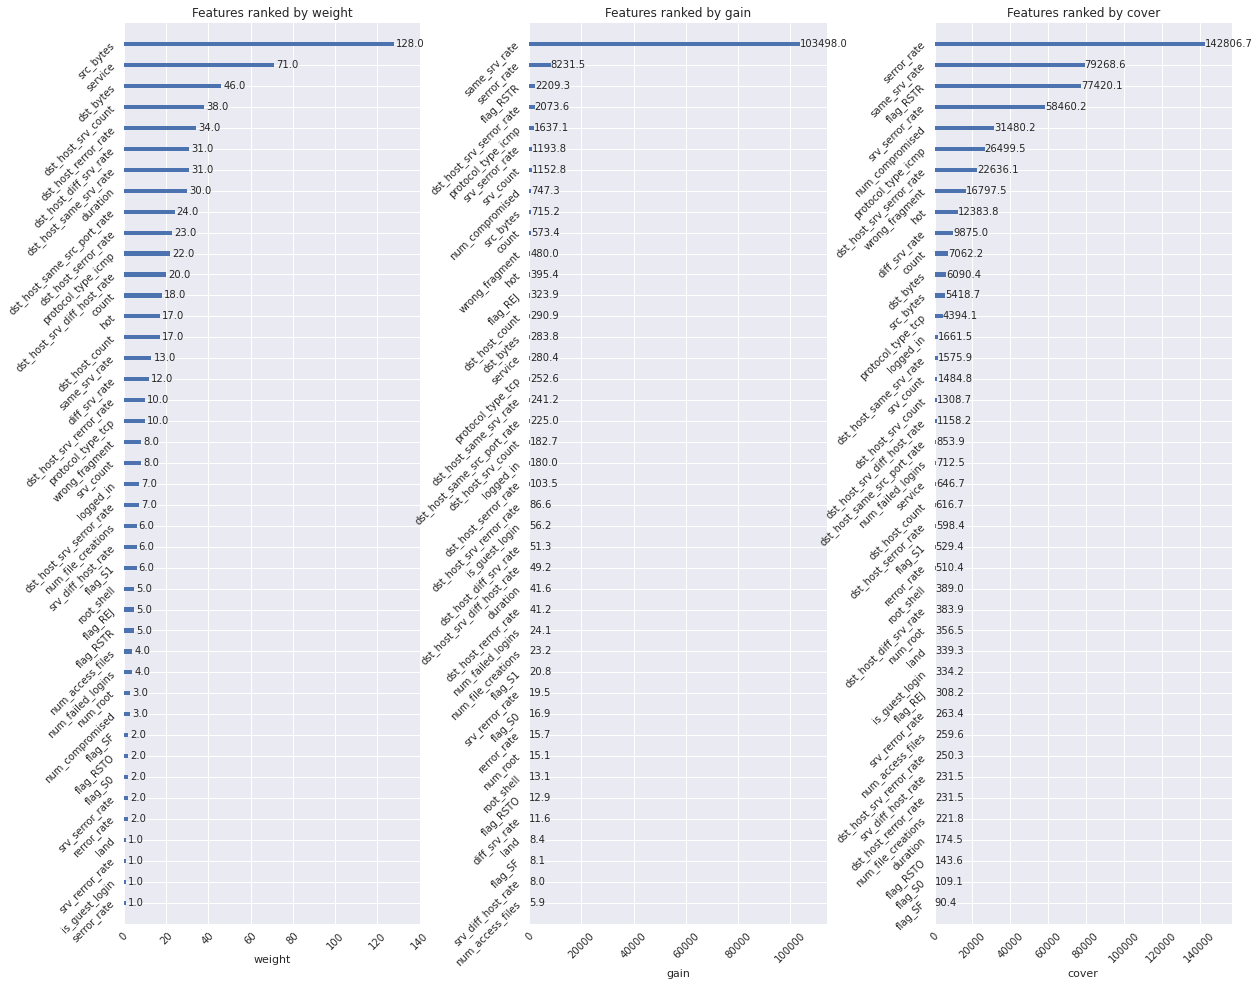

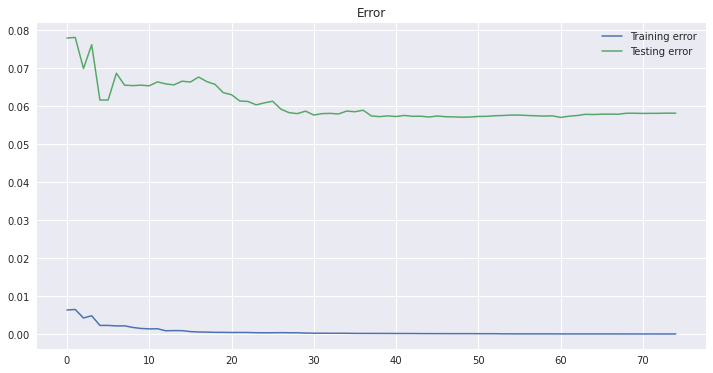

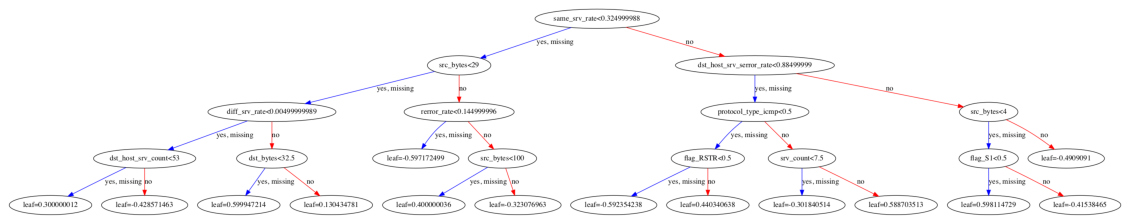

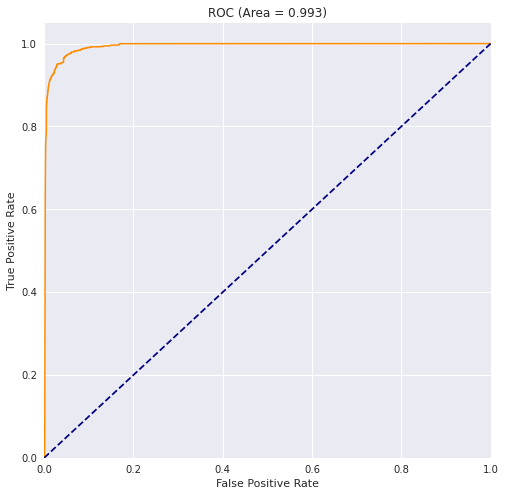

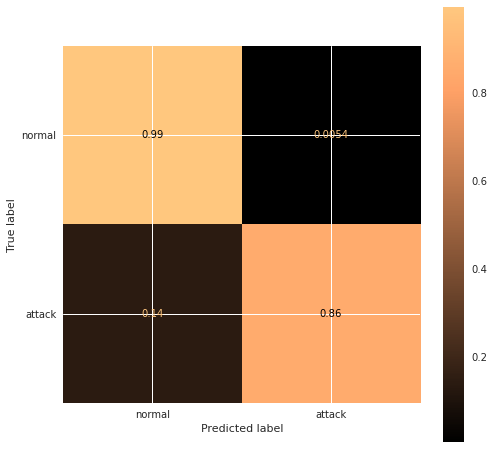

In [11]:
evaluation = model_helper.evaluate_model(X_test, y_test)

In [12]:
evaluation

{'accuracy': 0.9418431641458902,
 'balanced_accuracy': 0.8503916714659043,
 'prfs': {'precision': {'normal': 0.918349649271564,
   'attack': 0.9898421197684948},
  'recall': {'normal': 0.9946152401227224, 'attack': 0.8557764313431819},
  'f1_score': {'normal': 0.9549621762436752, 'attack': 0.9179400113186191},
  'support': {'normal': 47913.0, 'attack': 29378.0}},
 'test_target_proportions': {False: 0.6199039991719605,
  True: 0.38009600082803946},
 'model_params': {'objective': 'binary:logistic',
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 5,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.3,
  'max_delta_step': 0,
  'max_depth': 4,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 75,
  'n_jobs': 0,
  'num_parallel_tree': 1,
  'random_state': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
